A full documentation of the data we used, relavent links and relavent schema

Flights were sourced from here: https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv

Weather was sourced from here: https://asmith.ucdavis.edu/data/prism-weather

AirportLocations.csv was sourced from: https://geodata.bts.gov/datasets/usdot::aviation-facilities/about

For weather use the settings: Temporal unit should be daily, use county as spatial unit, start and end year are both 2015, months go from 1 to 12, states are all states, choose variables are tmin, tmax, tavg, ppt, dday_a5C, dday_b15C



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import kagglehub
import seaborn as sns

State regions were determined by the following image (kind of arbitrary). We decided to set AK to north and HI to pacific, this is here for the purpose of hypothesis testing later on

![Alt Text](region.png)

In [3]:
state_to_region_dict = {
    'WA': 'northwest',
    'OR': 'northwest',
    'ID': 'northwest',
    'MT': 'northwest',
    'WY': 'northwest',
    'CA': 'west',
    'NV': 'west',
    'UT': 'southwest',
    'AZ': 'southwest',
    'CO': 'southwest',
    'NM': 'southwest',
    'TX': 'southwest',
    'OK': 'southwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'NE': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'IA': 'midwest',
    'MO': 'midwest',
    'WI': 'midwest',
    'IL': 'midwest',
    'MI': 'midwest',
    'KY': 'midwest',
    'IN': 'midwest',
    'OH': 'midwest',
    'AR': 'southeast',
    'LA': 'southeast',
    'MS': 'southeast',
    'AL': 'southeast',
    'GA': 'southeast',
    'FL': 'southeast',
    'TN': 'southeast',
    'NC': 'southeast',
    'SC': 'southeast',
    'VA': 'midatlantic',
    'WV': 'midatlantic',
    'MD': 'midatlantic',
    'DE': 'midatlantic',
    'DC': 'midatlantic',
    'NJ': 'midatlantic',
    'PA': 'midatlantic',
    'NY': 'midatlantic',
    'CT': 'newengland',
    'RI': 'newengland',
    'MA': 'newengland',
    'NH': 'newengland',
    'VT': 'newengland',
    'ME': 'newengland',
    'AK': 'north',
    'HI': 'pacific'
}

In [4]:
flights_df = pl.read_csv('flights.csv')
airport_loc_df = pl.read_csv('AirportLocations.csv')
airlines_df = pl.read_csv('airlines.csv')
weather_df = pl.read_csv('weather.csv')

In [5]:
delays_df = flights_df.filter(pl.col("DEPARTURE_DELAY") > 0)
ontime_df = flights_df.filter(pl.col("DEPARTURE_DELAY") <= 0)

Joining the County information so that we can compare weather

In [6]:
airport_loc_df = airport_loc_df.select(["ARPT_ID", "COUNTY_NAME", "STATE_CODE"])
flights_df = flights_df.join(
    airport_loc_df, 
    left_on="ORIGIN_AIRPORT", 
    right_on="ARPT_ID", 
    how="left"
)
delays_df = flights_df.filter(pl.col("DEPARTURE_DELAY") > 0)
ontime_df = flights_df.filter(pl.col("DEPARTURE_DELAY") <= 0)
flights_df = flights_df.with_columns(
    pl.datetime(
        year=pl.col("YEAR"), 
        month=pl.col("MONTH"), 
        day=pl.col("DAY")
    ).cast(pl.Date).alias("date")
)
flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null,"""ANCHORAGE""","""AK""",2015-01-01
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-01-01
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""SAN MATEO""","""CA""",2015-01-01
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-01-01
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""KING""","""WA""",2015-01-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""LOS ANGELES""","""CA""",2015-12-31
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""QUEENS""","""NY""",2015-12-31
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""QUEENS""","""NY""",2015-12-31


Don't run the below cell more than once

In [7]:
weather_df = weather_df.with_columns(
    pl.col("date").cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias("date")
)
weather_df = weather_df.with_columns(
    pl.col("county_name").str.to_lowercase().alias("county_name")
)
weather_df

st_abb,st_code,county_name,fips,date,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
str,i64,str,i64,date,str,f64,f64,f64,f64,f64,f64
"""AL""",1,"""autauga""",1001,2015-01-01,"""stable""",-0.835,10.961,5.063,0.059,1.909,9.937
"""AL""",1,"""autauga""",1001,2015-01-02,"""stable""",0.276,13.216,6.746,3.863,3.008,8.254
"""AL""",1,"""autauga""",1001,2015-01-03,"""stable""",8.511,12.552,10.531,14.217,5.532,4.469
"""AL""",1,"""autauga""",1001,2015-01-04,"""stable""",12.328,20.585,16.457,48.919,11.456,0.668
"""AL""",1,"""autauga""",1001,2015-01-05,"""stable""",2.642,15.865,9.254,0.0,4.684,5.841
…,…,…,…,…,…,…,…,…,…,…,…
"""WY""",56,"""weston""",56045,2015-12-27,"""stable""",-19.242,-6.704,-12.973,0.0,0.0,27.973
"""WY""",56,"""weston""",56045,2015-12-28,"""stable""",-18.188,-2.366,-10.277,0.0,0.0,25.277
"""WY""",56,"""weston""",56045,2015-12-29,"""stable""",-20.651,-3.123,-11.887,0.0,0.0,26.887


Cross Referenced Data from here in order to ensure that the temperatures were correctly aligned: https://www.timeanddate.com/weather/usa/new-york/historic?month=12&year=2015

In [8]:
flights_df = flights_df.with_columns(
    pl.col("COUNTY_NAME").str.to_lowercase().alias("COUNTY_NAME")
)

result_df = flights_df.join(
    weather_df,
    left_on=["COUNTY_NAME", "date", "STATE_CODE"],
    right_on=["county_name", "date", "st_abb"],
    how="left"
)

flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null,"""anchorage""","""AK""",2015-01-01
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""king""","""WA""",2015-01-01
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-12-31
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31


In [9]:
'''
result_df2 = flights_df.join(
    weather_df,
    left_on=["COUNTY_NAME", "date"],
    right_on=["county_name", "date"],
    how="inner"
)

result_df2
'''

'\nresult_df2 = flights_df.join(\n    weather_df,\n    left_on=["COUNTY_NAME", "date"],\n    right_on=["county_name", "date"],\n    how="inner"\n)\n\nresult_df2\n'

In [10]:
result_important_df = result_df.filter(pl.col('tavg').is_not_null())
result_important_df = result_important_df.with_columns(
    (pl.col('DEPARTURE_DELAY') + pl.col('ARRIVAL_DELAY')).alias('TOTAL_DELAY')
)
result_important_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date,i64,i64,str,f64,f64,f64,f64,f64,f64,i64
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-17
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-01-01,6,6037,"""stable""",-2.162,7.71,2.774,0.009,0.621,12.226,-14
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null,"""king""","""WA""",2015-01-01,53,53033,"""stable""",-6.204,0.605,-2.8,0.061,0.0,17.8,-22
2015,1,1,4,"""DL""",806,"""N3730B""","""SFO""","""MSP""",25,20,-5,18,38,217,230,206,1589,604,6,602,610,8,0,0,null,null,null,null,null,null,"""san mateo""","""CA""",2015-01-01,6,6081,"""stable""",2.561,12.746,7.654,0.0,3.173,7.346,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,12,31,4,"""B6""",688,"""N657JB""","""LAX""","""BOS""",2359,2355,-4,22,17,320,298,272,2611,749,4,819,753,-26,0,0,null,null,null,null,null,null,"""los angeles""","""CA""",2015-12-31,6,6037,"""stable""",-0.456,13.363,6.454,0.0,2.975,8.546,-30
2015,12,31,4,"""B6""",745,"""N828JB""","""JFK""","""PSE""",2359,2355,-4,17,12,227,215,195,1617,427,3,446,430,-16,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31,36,36081,"""stable""",4.968,9.84,7.404,8.014,2.405,7.596,-20
2015,12,31,4,"""B6""",1503,"""N913JB""","""JFK""","""SJU""",2359,2350,-9,17,7,221,222,197,1598,424,8,440,432,-8,0,0,null,null,null,null,null,null,"""queens""","""NY""",2015-12-31,36,36081,"""stable""",4.968,9.84,7.404,8.014,2.405,7.596,-17


We will now split in to test and train sets and proceed with EDA on the train set

In [11]:
from sklearn.model_selection import train_test_split

target = ['DEPARTURE_DELAY']

X_train, X_test = train_test_split(result_important_df, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(3946641, 44)
(986661, 44)


Let us now get some understanding of what our data looks like

In [12]:
basic_stats = X_train.describe()
info = X_train.schema
columns_of_interest = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'DISTANCE', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C', 'dday_b15C']
X_train_numerical = X_train.select(columns_of_interest)
df = X_train_numerical.to_pandas()
corr_matrix = df.corr()
corr_matrix

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
SCHEDULED_DEPARTURE,1.000000,0.962233,0.115284,0.003903,0.935480,-0.034572,-0.032146,0.659905,-0.027640,0.105271,-0.001100,0.012024,0.019178,0.015066,0.017344,0.005907,0.015707,-0.017254
DEPARTURE_TIME,0.962233,1.000000,0.178411,0.011233,0.971042,-0.038370,-0.037361,0.680601,-0.034474,0.166297,0.001254,0.008537,0.015856,0.010246,0.013188,0.013549,0.013354,-0.011402
DEPARTURE_DELAY,0.115284,0.178411,1.000000,0.057032,0.168854,0.028974,0.021429,0.059745,0.022554,0.945319,0.022244,0.031957,0.001969,-0.015177,-0.006960,0.060322,0.009501,0.028679
TAXI_OUT,0.003903,0.011233,0.057032,1.000000,0.036449,0.209675,0.086574,0.028740,0.071450,0.228042,0.011847,0.005653,-0.055480,-0.089860,-0.074373,0.032480,-0.052435,0.093206
WHEELS_OFF,0.935480,0.971042,0.168854,0.036449,1.000000,-0.043546,-0.046082,0.701176,-0.045990,0.161964,0.001438,0.005178,0.014069,0.006840,0.010525,0.014787,0.011508,-0.008076
ELAPSED_TIME,-0.034572,-0.038370,0.028974,0.209675,-0.043546,1.000000,0.989078,0.027310,0.971945,0.033532,NaN,NaN,0.003841,-0.015541,-0.006225,-0.006967,-0.009281,0.001395
AIR_TIME,-0.032146,-0.037361,0.021429,0.086574,-0.046082,0.989078,1.000000,0.024980,0.984889,-0.004563,NaN,NaN,0.011677,-0.003690,0.003840,-0.011555,-0.002962,-0.012147
WHEELS_ON,0.659905,0.680601,0.059745,0.028740,0.701176,0.027310,0.024980,1.000000,0.022695,0.059274,0.006916,NaN,-0.000731,-0.004399,-0.002660,0.005032,-0.003745,0.000882
DISTANCE,-0.027640,-0.034474,0.022554,0.071450,-0.045990,0.971945,0.984889,0.022695,1.000000,-0.023186,0.013365,-0.034271,0.027400,0.018948,0.023433,-0.020159,0.013118,-0.034439
ARRIVAL_DELAY,0.105271,0.166297,0.945319,0.228042,0.161964,0.033532,-0.004563,0.059274,-0.023186,1.000000,NaN,NaN,-0.001721,-0.016689,-0.009573,0.065270,0.008151,0.032704


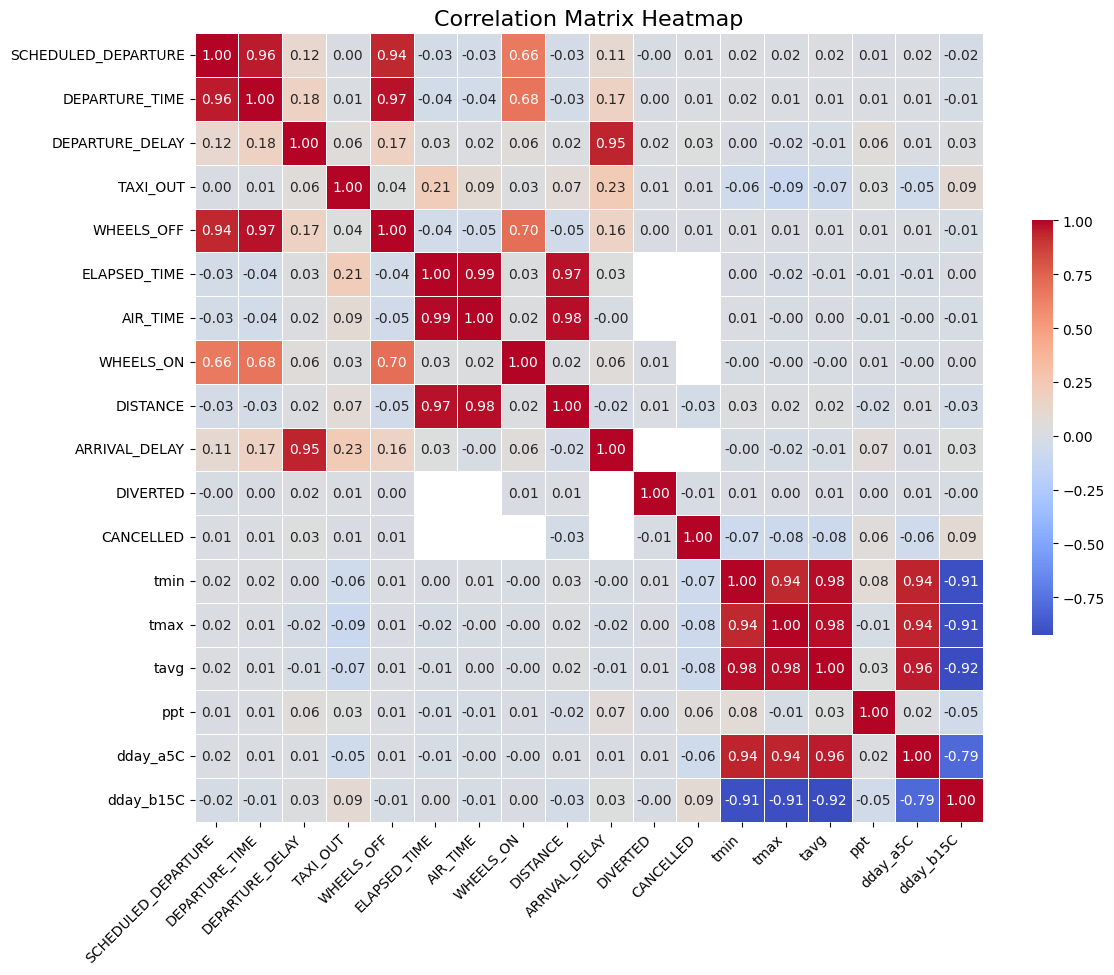

In [13]:
'''
VISUAL 1: Naturally as we are interested in DEPARTURE and ARRIVAL delay when choosing features, we should choose features that seem to be highly correlated with these delays
We will use 2 metrics that I think do a good job of measuring correlation, 1 is the standard pearson correlation, then to compare categorical values we will use the CramerV correlation metric
'''
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


As we can see there are very weak correlations, but what if we filter for precipitation > 1?

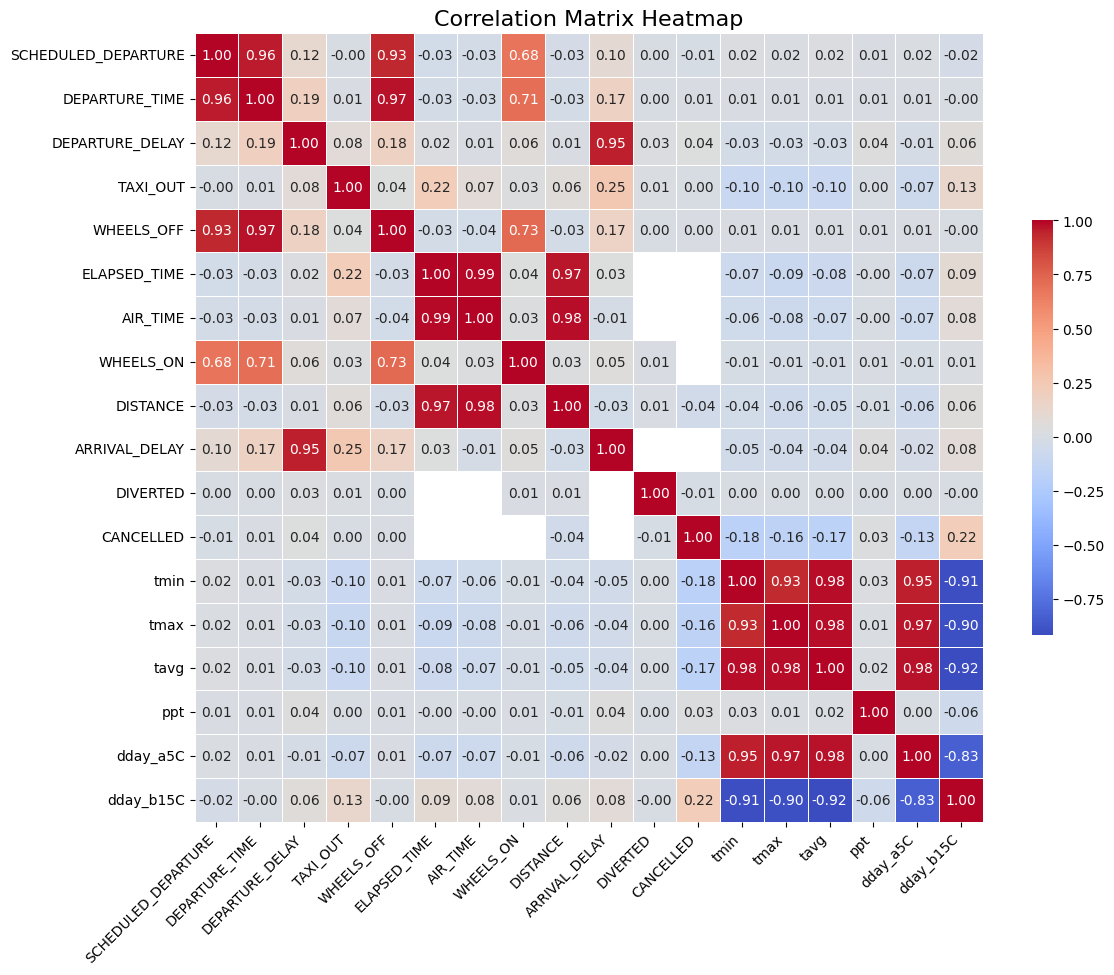

(613346, 18)


In [14]:
df_ppt_filtered = df[df['ppt'] > 5]
corr_matrix = df_ppt_filtered.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(df_ppt_filtered.shape)

C:\Users\nball\AppData\Local\Temp\ipykernel_16204\2889801515.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()


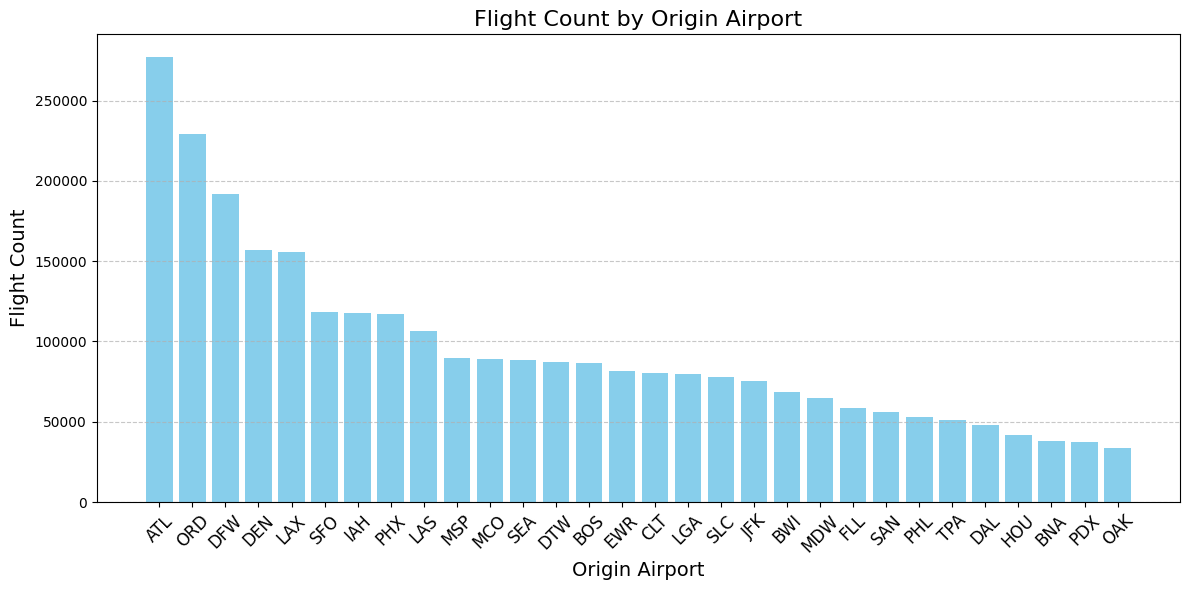

In [15]:
origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()
origin_counts_pd = origin_counts.to_pandas()
origin_counts_pd = origin_counts_pd.sort_values(by="count", ascending=False)
top_30 = origin_counts_pd.head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_30["ORIGIN_AIRPORT"], top_30["count"], color="skyblue")
plt.xlabel("Origin Airport", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Flight Count by Origin Airport", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\nball\AppData\Local\Temp\ipykernel_16204\1305936786.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  airline_counts = X_train.group_by("AIRLINE").count()


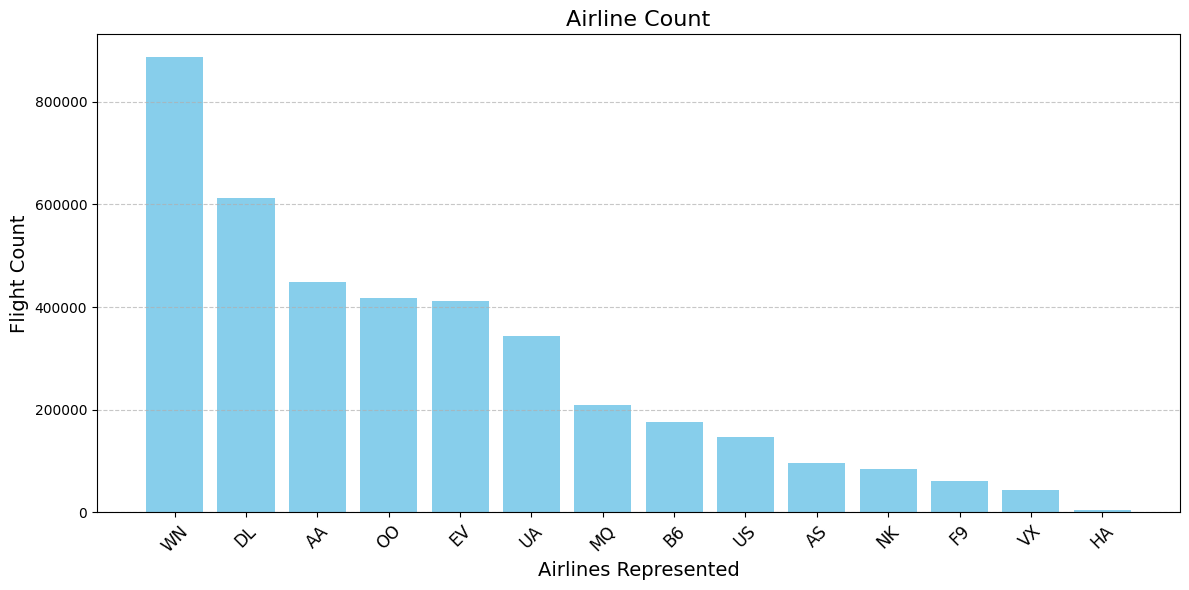

In [16]:
airline_counts = X_train.group_by("AIRLINE").count()
airline_counts = airline_counts.to_pandas()
airline_counts = airline_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(airline_counts["AIRLINE"], airline_counts["count"], color="skyblue")
plt.xlabel("Airlines Represented", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Airline Count", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Now for some feature importance! We have a few modeling ideas

1) Given delay, weather, location, and other features in the dataframe, can we accurately predict which airline caused the delay

2) Conversely given an airline, weather, origin, destination, and other features, can we accurately predict the total delay (arrival + departure delay)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

target = ['TOTAL_DELAY']
y_train = X_train.select(target)
X_train_total_delay = X_train.drop(target)

non_numeric_cols = [col for col in X_train_total_delay.columns if X_train_total_delay[col].dtype == pl.Utf8]
encoded_non_numeric = X_train_total_delay
for col in non_numeric_cols:
    le = LabelEncoder()
    encoded_non_numeric = encoded_non_numeric.with_columns(
        pl.Series(name=col, values=le.fit_transform(encoded_non_numeric[col].to_list()))
    )
print(non_numeric_cols)
X_train_total_delay = encoded_non_numeric
X_train_total_delay = pl.concat([X_train_total_delay, y_train], how="horizontal")
X_train_total_delay_cleaned = X_train_total_delay.filter(
    pl.col("TOTAL_DELAY").is_not_null()
)

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLATION_REASON', 'COUNTY_NAME', 'STATE_CODE', 'stability']


In [27]:
target = ['TOTAL_DELAY']
y_train = X_train_total_delay_cleaned.select(target)
X_train_total_delay = X_train_total_delay_cleaned.drop(target)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Int32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Int64]
)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Float32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Float64]
)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_train_total_delay)
X_standardized_pl = pl.DataFrame(
    X_standardized, schema=X_train_total_delay.columns
)
X_standardized_pl = X_standardized_pl.drop_nulls()
# rf = RandomForestClassifier(random_state=0)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_total_delay_cleaned, y_train, test_size=0.4)

lr = LinearRegression()
lr.fit(X_standardized_pl, y_train)

feature_importances = pd.DataFrame({
    "Feature": X_standardized.columns,
    "Importance": np.abs(lr.coef_)
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(X_standardized["Feature"], X_standardized["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Random Forest")
plt.gca().invert_yaxis()
plt.show()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Now it is time to move into some hypothesis testing

We will be looking at the following hypotheses all tested with $\alpha = 0.05$ for significance:

1) When precipitation is greater than 1 is a flight more likely to be delayed?

$H_0$: When precipitation is greater than 1 a flight has the same liklihood of being delayed

2) Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months?

$H_0$: western, southwestern, and southeastern states are delayed the same amount as flights in the midwest, new england, mid-atlantic, and the northwest in winter months.

3) Some of us have had some bad experience with certain airlines (looking at you AA), is this the truth, are some airlines significantly more likely to have delays than others?

$H_0$: all airlines experience the same average delay

In [29]:
# Don't run the following two lines more than once very bad for RAM
precip_df = result_important_df.filter(pl.col("ppt") > 1)
noprecip_df = result_important_df.filter(pl.col("ppt") <= 1)

In [36]:
'''
HYPOTHESIS 1
'''
# TOTAL: 4,933,302 rows
# (a) Are we are testing a population proportion - looking at the proportion of flights that are delayed (as binary)
#     We are testing the difference of population proportions
#     H_0: p_precip - p_noprecip = 0, H_1: p_precip - p_noprecip > 0
# (b) Or are we testing like based on the actual number of minutes - the mean delay time - which would be inference on the mean

# (a)
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
precip_df = precip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
noprecip_df = noprecip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_precip_proportion = precip_df.select(pl.sum('IS_DELAYED')) / len(precip_df)
delay_noprecip_proportion = noprecip_df.select(pl.sum('IS_DELAYED')) / len(noprecip_df)

# Calculate original test statistic (0.420968 - 0.354947 = 0.066021)
delay_proportion_diff = delay_precip_proportion[0, 0] - delay_noprecip_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of precipitation, 10,000,000 trials each
simulated_delays_precip = np.random.binomial(len(precip_df), 0.5, 10_000_000) / len(precip_df)
simulated_delays_noprecip = np.random.binomial(len(noprecip_df), 0.5, 10_000_000) / len(noprecip_df)
simulated_precip_proportion = sum(simulated_delays_precip) / len(simulated_delays_precip)
simulated_noprecip_proportion = sum(simulated_delays_noprecip) / len(simulated_delays_noprecip)
# simulated values: (0.500 - 0.499 = -3.615e-08)
simulated_proportion_diff = simulated_precip_proportion - simulated_noprecip_proportion

# Calculate the p-value (p = 0)
simulated_p_value = sum(x >= delay_proportion_diff for x in (simulated_delays_precip - simulated_delays_noprecip)) / len(simulated_delays_precip)
print(simulated_p_value)

0.0


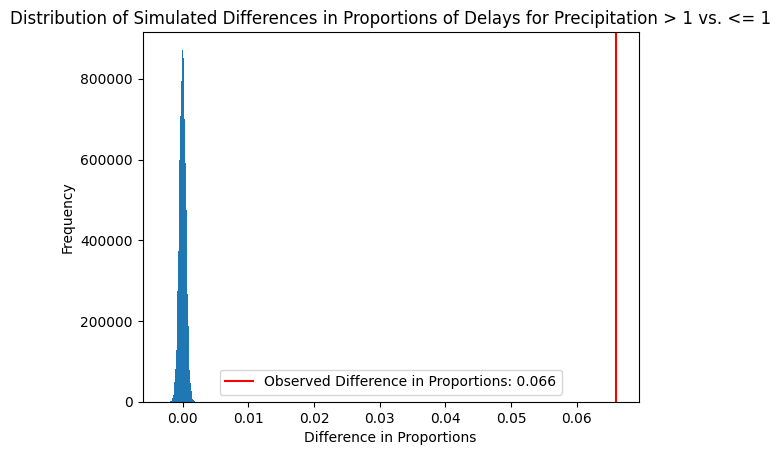

In [37]:
# Plot the distribution of simulated difference in proportions of delays for precipitation > 1 vs. <= 1
_ = plt.hist(simulated_delays_precip - simulated_delays_noprecip, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Precipitation > 1 vs. <= 1")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()

In [38]:
'''
HYPOTHESIS 2: 
Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months?
H_0: western, southwestern, and southeastern states are delayed the same amount as flights in the midwest, new england, and the northwest in winter months.
H_0: p_north - p_south = 0, H_1: p_north - p_south > 0
'''
# Winter months: December - February (12, 1, 2), need to use state_to_region_dict to get region classifications
# Convert state_to_region_dict to a dataframe for joining purposes
state_to_region_df = pl.from_dict(state_to_region_dict)
states = pl.Series(state_to_region_df.columns)
state_to_region_df = state_to_region_df.transpose()
state_to_region_df = state_to_region_df.insert_column(1, states)
state_to_region_df.columns = ['region', 'STATE_CODE']
# Join result_important_df with this to add a new column with the regions
result_important_df = result_important_df.join(state_to_region_df, on = 'STATE_CODE', how = 'left')

In [39]:
# Compute smaller dfs: south = western + southerwestern + southeast, north = midwest + new england + mid-atlantic + northwest
# Then filter for winter months
south_df = result_important_df.filter((pl.col("region") == "western") | (pl.col("region") == "southwest") | (pl.col("region") == "southeast"))
north_df = result_important_df.filter((pl.col("region") == "midwest") | (pl.col("region") == "newengland") |
 (pl.col("region") == "midatlantic") | (pl.col("region") == "northwest"))
south_df = south_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))
north_df = north_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))

In [41]:
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
south_df = south_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
north_df = north_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_south_proportion = south_df.select(pl.sum('IS_DELAYED')) / len(south_df)
delay_north_proportion = north_df.select(pl.sum('IS_DELAYED')) / len(north_df)

# Calculate original test statistic (0.399198 - 0.386936 = 0.012262)
delay_proportion_diff1 = delay_north_proportion[0, 0] - delay_south_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of north/south, 10,000,000 trials each
simulated_delays_north = np.random.binomial(len(north_df), 0.5, 10_000_000) / len(north_df)
simulated_delays_south = np.random.binomial(len(south_df), 0.5, 10_000_000) / len(south_df)
simulated_north_proportion = sum(simulated_delays_north) / len(simulated_delays_north)
simulated_south_proportion = sum(simulated_delays_south) / len(simulated_delays_south)
# simulated values: (0.500 - 0.500 = 0)
simulated_proportion_diff1 = simulated_north_proportion - simulated_south_proportion

# Calculate the p-value (p = 0)
simulated_p_value1 = sum(x >= delay_proportion_diff1 for x in (simulated_delays_north - simulated_delays_south)) / len(simulated_delays_north)
print(simulated_p_value1)

0.0


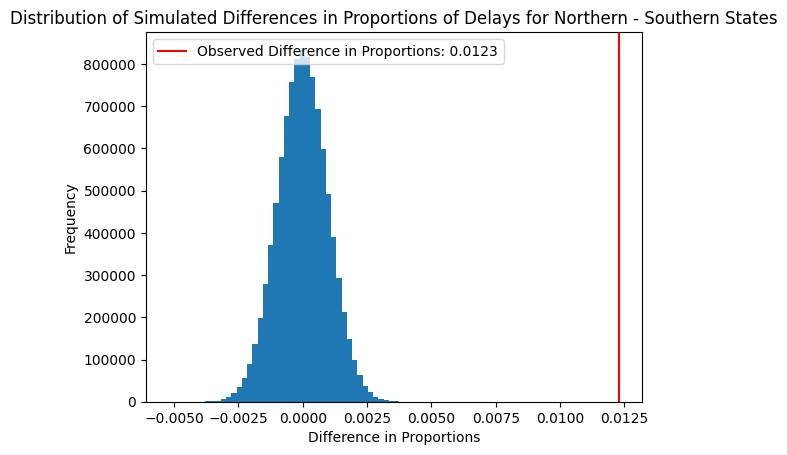

In [42]:
# Plot the distribution of simulated difference in proportions of delays for north vs. south states
_ = plt.hist(simulated_delays_north - simulated_delays_south, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Northern - Southern States")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff1, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()